# using min-stats-noise-estimation API

In [1]:
from scipy import integrate, fftpack, signal, io, stats
import numpy as np
import scipy.io.wavfile
from matplotlib import pyplot as plt
import matplotlib as mp
from minstatsnoisest import NoiseEstimator

In [2]:
# initialization for bandwidth of audio wav file
samp_rate, sig = io.wavfile.read("Casio-MT-45-16-Beat.wav")
# extract mono signal
sig = sig.mean(axis=1)
max_time = len(sig)/samp_rate
t = np.linspace(0, max_time, len(sig))

<ipython-input-2-f3b41f8689ac>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samp_rate, sig = io.wavfile.read("Casio-MT-45-16-Beat.wav")


In [3]:
# get the complex signal of a signal
def complex_sig(real_sig):
    return signal.hilbert(real_sig)

In [4]:
comp_sig = complex_sig(sig)

In [5]:
def add_wgnoise(sig):
    # get power of signal
    sig_pow = np.var(sig)
    # compute noise power at 5dB SNR
    snr_lin = 10**(10/10)
    noise_pow = sig_pow/snr_lin
    noise = stats.norm(0, np.sqrt(noise_pow))
    return sig + noise.rvs(*np.shape(sig))

In [6]:
sig_plus_noise = add_wgnoise(comp_sig)

In [7]:
# plot fft of sig
nfft = 1024
F_sig_plus_noise = fftpack.fft(sig_plus_noise, nfft)
f = np.linspace(0, samp_rate, nfft)

In [8]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        F_slide_arr = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                print("The initial noise power is ", float(F_slide[0:1]))
                ne = NoiseEstimator(nfft, float(F_slide[0:1]))
                
            noise_estimate = ne.compute(F_slide) 
            F_slide_arr[i, :] = F_slide
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = ne.getalpha()
            
        return F_slide_arr, noise_estimate_arr, niteration, valpha_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")

In [9]:
F_slide_fft, noise_floor_est, niteration, valpha = noise_floor_estimate(sig_plus_noise, samp_rate)

The initial noise power is  0.1791996494944475
The average normalized variance in PSD samples is  0.0
The average normalized variance in PSD samples is  0.28202985807395403
The average normalized variance in PSD samples is  0.4976779225960441
The average normalized variance in PSD samples is  0.46332215382817404
The average normalized variance in PSD samples is  0.46536680815250436
The average normalized variance in PSD samples is  0.3938169806825616
The average normalized variance in PSD samples is  0.4726894153655728
The average normalized variance in PSD samples is  0.43683542712222606


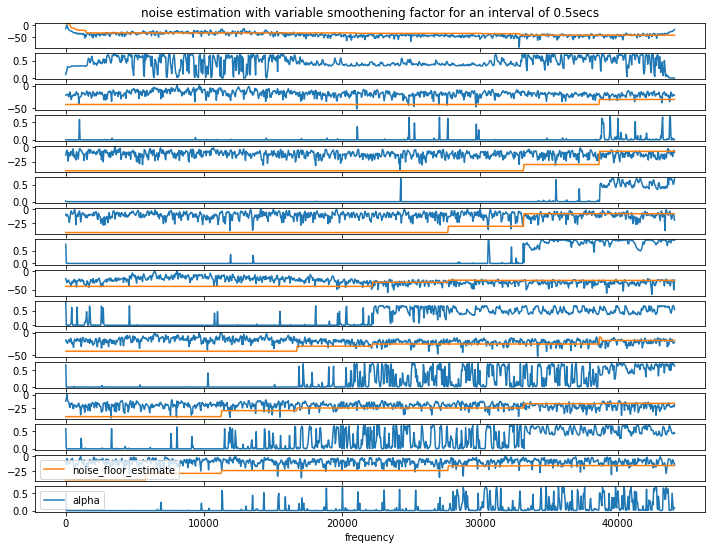

In [10]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,9))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])))
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()